In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import os
import neurokit2 as nk #TODO look into this algorithm
from tqdm import tqdm
import scipy.io
from scipy.sparse import csc_matrix, spdiags
from scipy.sparse.linalg import spsolve

In [2]:
print('finding names of all test files ...')
all_files = []

for root, dirs, files in os.walk("F:\\DATA\\JSmith_SAFER_20220310\\raw_data\\Feas1\\ECGs"):
    for file in files:
        if(file.endswith(".dat")):
            all_files.append(os.path.join(root,file.split(".dat",2)[0]))
print('all files found :)')

finding names of all test files ...
all files found :)


In [3]:
indices = np.array([i for i in range(50)])*1000
indices

array([    0,  1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,
        9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000,
       18000, 19000, 20000, 21000, 22000, 23000, 24000, 25000, 26000,
       27000, 28000, 29000, 30000, 31000, 32000, 33000, 34000, 35000,
       36000, 37000, 38000, 39000, 40000, 41000, 42000, 43000, 44000,
       45000, 46000, 47000, 48000, 49000])

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


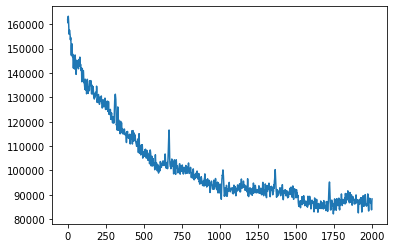

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\001000\saferF1_001001


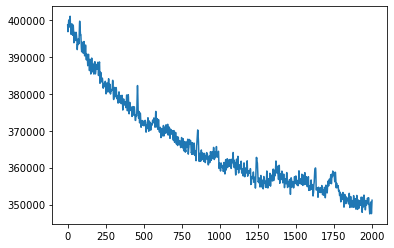

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\002000\saferF1_002001


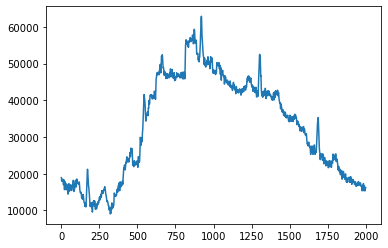

<Figure size 432x288 with 0 Axes>

In [4]:
for test_file in all_files[::1000][:3]:
    print(test_file)
    record = wfdb.rdrecord(test_file)
    entire_ecg_signal = record.p_signal.T[0]
    plt.plot(entire_ecg_signal[:2000])
    plt.show()
    plt.clf()

# Experimenting with baseline_als

Experimenting with different lam "smoothing" parameter, and other paramteres, to take out baseline drift
https://stackoverflow.com/questions/29156532/python-baseline-correction-library

In [22]:
def baseline_als(y, lam=1e6, p=0.01, niter=10):
    L = len(y)
    D = csc_matrix(np.diff(np.eye(L), 2))
    w = np.ones(L)
    for i in np.arange(niter):
        W = spdiags(w, 0, L, L)
        Z = W + lam * D.dot(D.transpose())
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


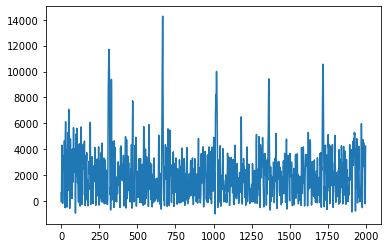

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


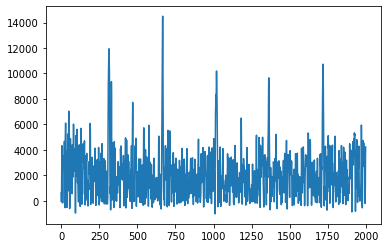

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


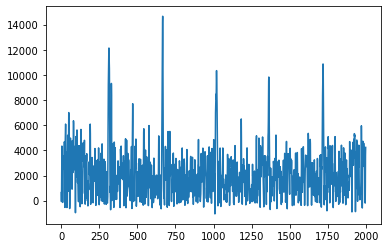

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


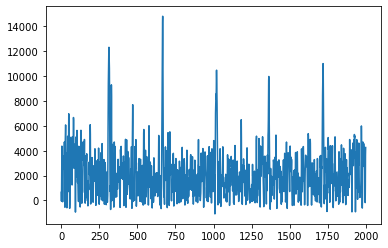

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


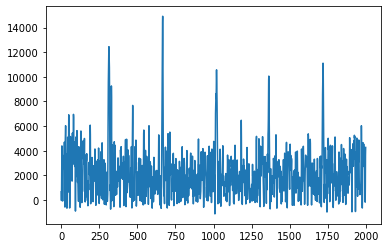

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


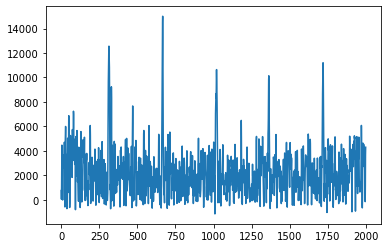

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


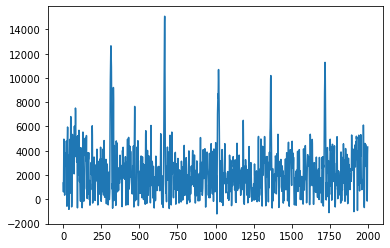

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


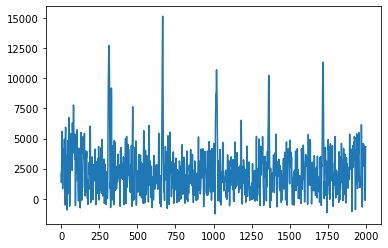

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


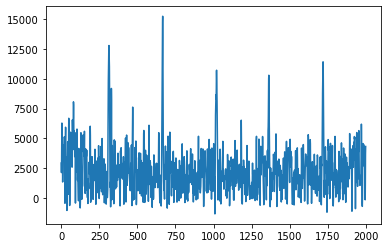

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


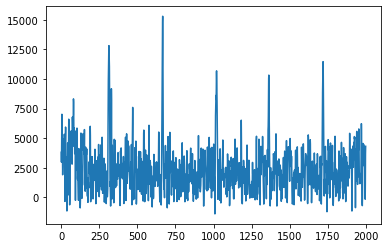

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


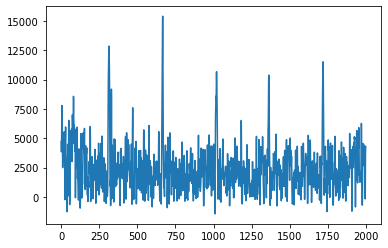

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


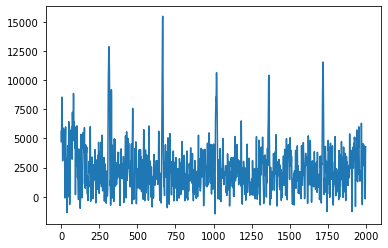

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


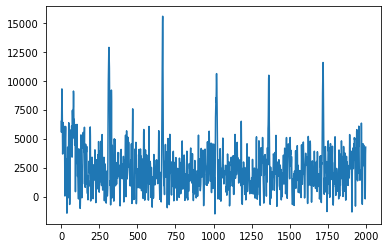

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


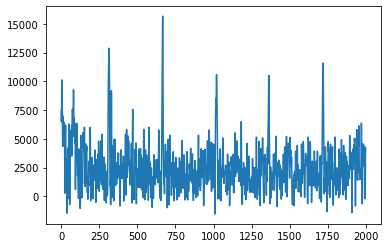

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


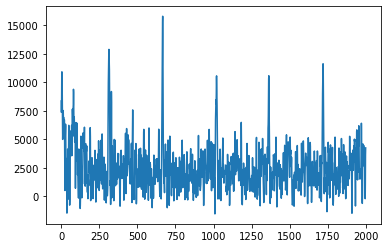

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


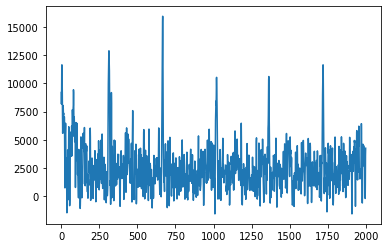

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


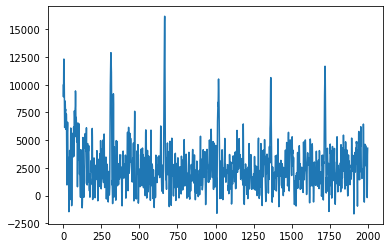

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


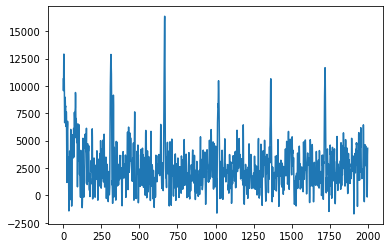

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


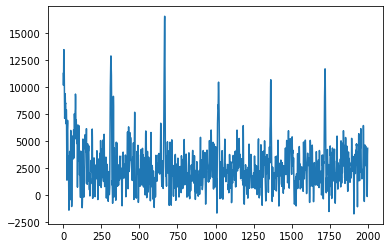

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


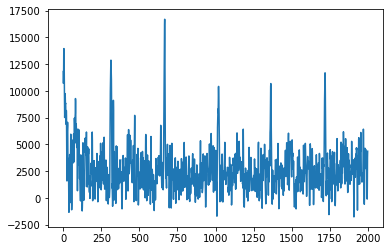

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


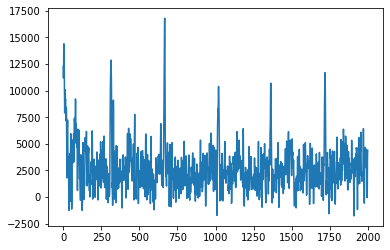

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


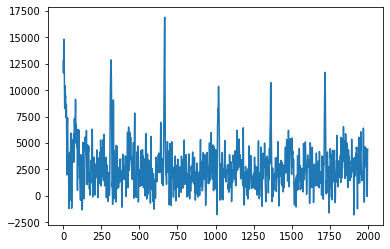

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


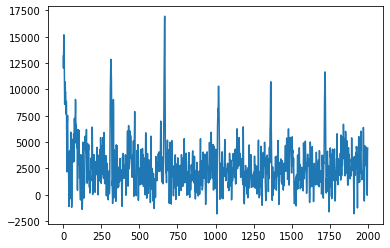

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


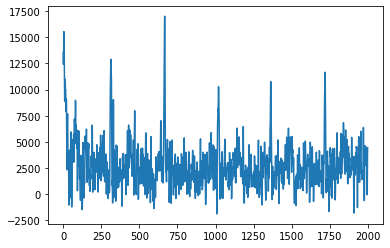

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


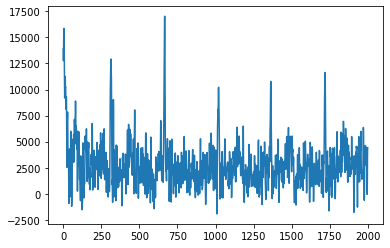

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


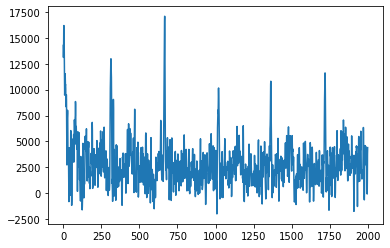

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


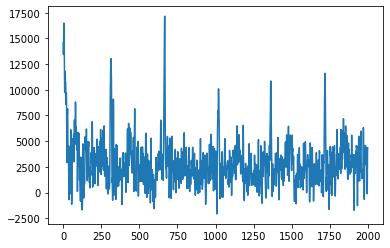

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


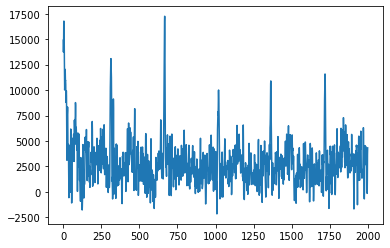

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


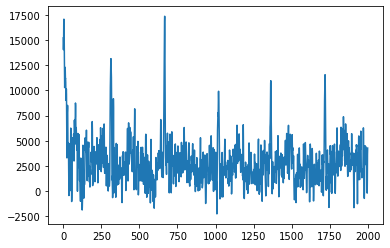

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


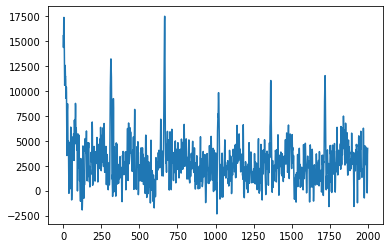

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


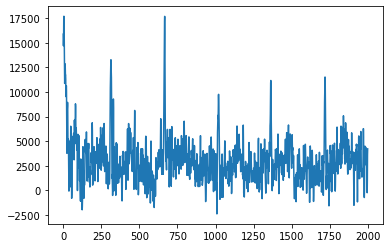

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


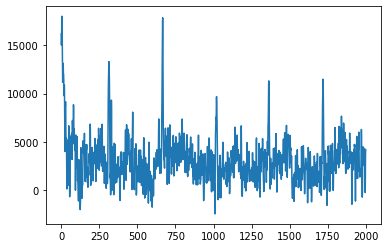

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


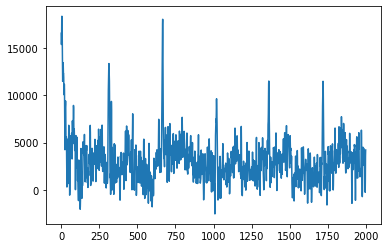

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


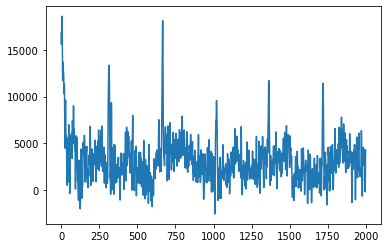

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


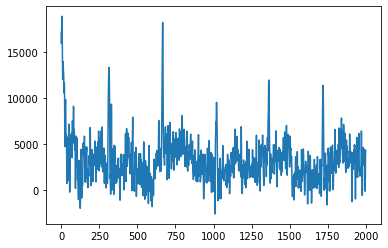

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


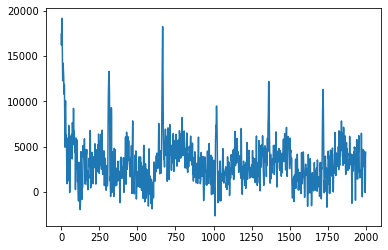

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


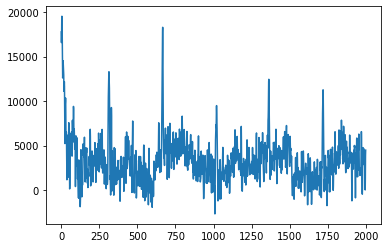

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


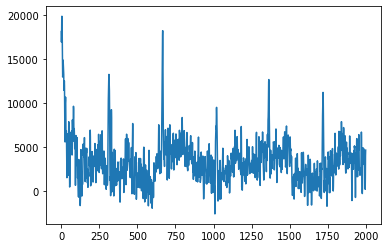

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


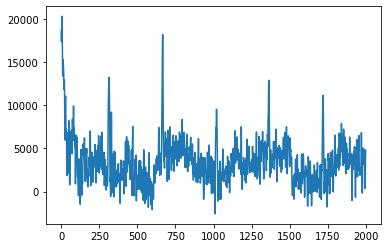

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


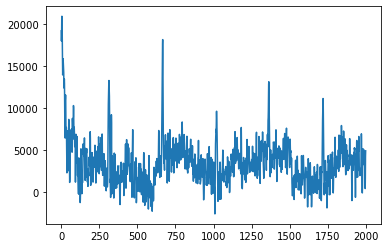

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


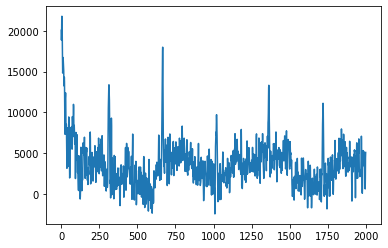

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


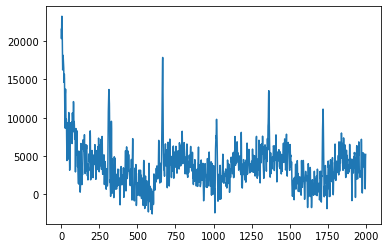

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


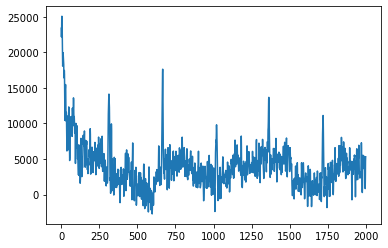

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


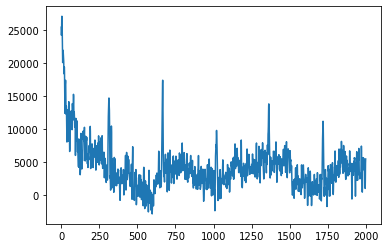

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


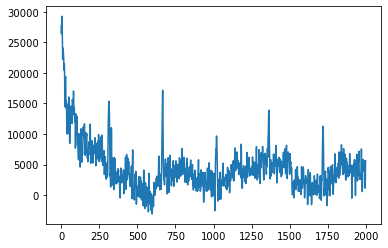

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


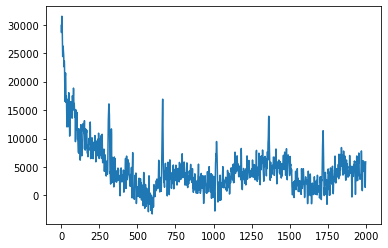

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


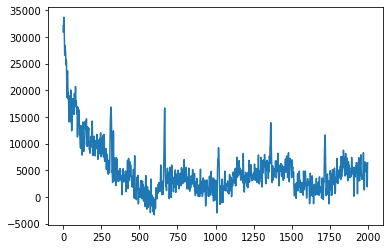

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


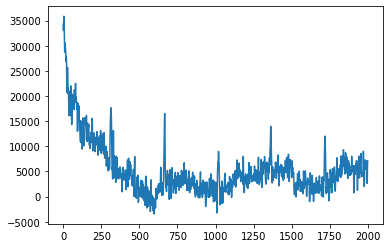

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


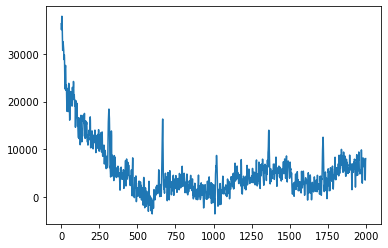

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


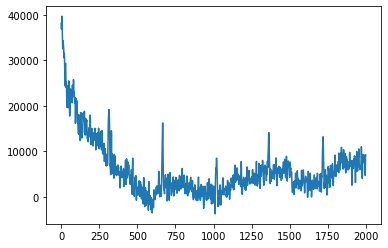

<Figure size 432x288 with 0 Axes>

In [26]:
for lam_ in np.logspace(2,9):
    for test_file in all_files[::1000][:1]:
        print(test_file)
        record = wfdb.rdrecord(test_file)
        entire_ecg_signal = record.p_signal.T[0]
        plt.plot(entire_ecg_signal[:2000] - baseline_als(entire_ecg_signal[:2000], lam=lam_))
        plt.show()
        plt.clf()

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


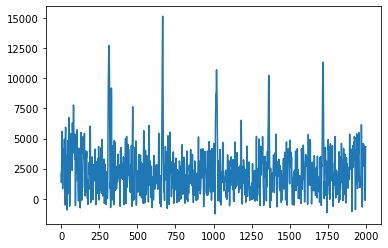

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\001000\saferF1_001001


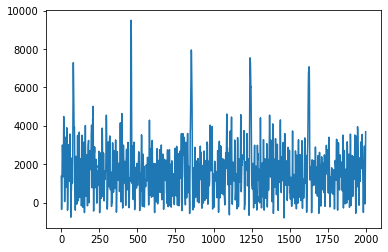

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\002000\saferF1_002001


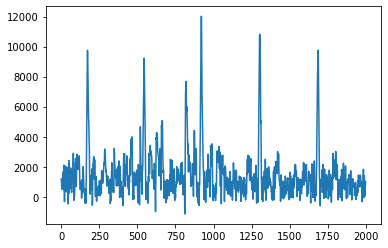

<Figure size 432x288 with 0 Axes>

In [27]:
for test_file in all_files[::1000][:3]:
    print(test_file)
    record = wfdb.rdrecord(test_file)
    entire_ecg_signal = record.p_signal.T[0]
    plt.plot(entire_ecg_signal[:2000] - baseline_als(entire_ecg_signal[:2000]))
    plt.show()
    plt.clf()

## Experiment with smoothing/ low pass filtering


F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\000000\saferF1_000001


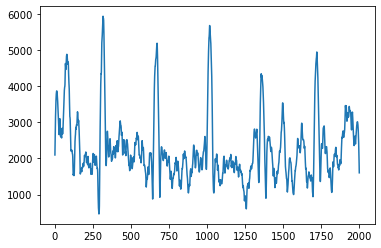

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\001000\saferF1_001001


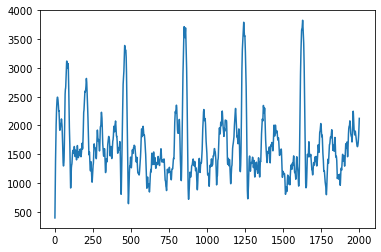

F:\DATA\JSmith_SAFER_20220310\raw_data\Feas1\ECGs\002000\saferF1_002001


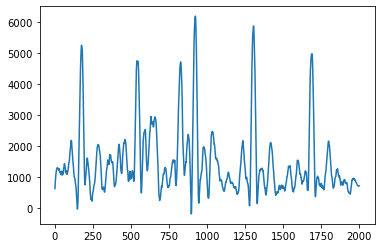

<Figure size 432x288 with 0 Axes>

In [29]:
from scipy.signal import savgol_filter

for test_file in all_files[::1000][:3]:
    print(test_file)
    record = wfdb.rdrecord(test_file)
    entire_ecg_signal = record.p_signal.T[0]
    signal_no_wander = entire_ecg_signal[:2000] - baseline_als(entire_ecg_signal[:2000])
    signal_lpf = savgol_filter(signal_no_wander, 51, 3)
    plt.plot(signal_lpf)
    plt.show()
    plt.clf()



Idea, potentially train the smoothing parameters to each patient by adjusting to least likely to show "~" prediction.